In [2]:
from classy import Class
import numpy as np
import scipy.interpolate as inter
from scipy.integrate import quad
from numpy import log, sin, cos, pi
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import os

In [3]:
envkey = 'OMP_NUM_THREADS'
print("The value of {:s} is: ".format(envkey), os.environ.get(envkey))
os.environ[envkey] = str(8)
os.environ[envkey] = str(8)
print("The value of {:s} is: ".format(envkey), os.environ.get(envkey))

The value of OMP_NUM_THREADS is:  None
The value of OMP_NUM_THREADS is:  8


In [4]:
cosmo = Class()
cosmo.set_default()
cosmo.set({'output':'mPk',
           'z_max_pk':5,
           'P_k_max_1/Mpc':1.e3
            })
cosmo.compute()

In [5]:
k_size = 100
z_size = 100

z_grid =np.array(np.linspace(0,5,z_size))
k_grid =np.logspace(-4,3,k_size,base=10)


In [6]:
p_kz_lin = np.zeros((k_size,z_size))
for zi, zz in enumerate(z_grid):
    for ki, kk in enumerate(k_grid):
        p_kz_lin[ki,zi]= cosmo.pk_lin(kk,zz)
p_kz_lin_spline = inter.RectBivariateSpline(k_grid,z_grid,p_kz_lin)

In [7]:
H_z=np.zeros(z_size)
Om_z = np.zeros(z_size)
for zi, zz in enumerate(z_grid):
    H_z[zi]=cosmo.Hubble(zz)*2.98e8
    Om_z = cosmo.Om_m(zz)

_G = 6.67259 * 10e-11 
_Mpc = 3e22

rho_c = 3 * np.power(H_z,2) / ( 8 * pi * _G) * _Mpc
rho_z = Om_z * rho_c

rho_z_spline = inter.CubicSpline(z_grid,rho_z)

def M_to_R(M,z):
    return np.power(M * 3/ (4 * pi * rho_z_spline(z)),1/3)

In [8]:
def W(M,z,k):
    return 4 * pi / np.power(k,3) * ( sin(k * M_to_R(M,z))-k * M_to_R(M,z) * cos (k * M_to_R(M,z)))
    #return  2*sin(k*M_to_R(M,z)/2)/(k*M_to_R(M,z)) # ?

In [9]:
def sigma_sqr(M,z): 
   return quad(lambda k: np.power(k,2)*(p_kz_lin_spline(k,z)) * np.power(W(M,z,k),2),1e-4,1e3)[0]

In [10]:
#not sure ob wir das brauchen aber ich hab keinen extrapolator
def pk_lin_fitting(x,b1,b2,b3):
    return b1*np.power(x,0.9626-4)*np.power(b2+log(x+b3),2)
fitting_range_k=np.logspace(1,3,100,base=10)
popt, pcov = curve_fit(pk_lin_fitting,fitting_range_k,(p_kz_lin_spline(fitting_range_k,0)).flatten())
print(popt)

[10.82297402  2.89229975 -0.20227813]


/tmp/ipykernel_12713/3438864796.py:3: RuntimeWarning: invalid value encountered in log
  return b1*np.power(x,0.9626-4)*np.power(b2+log(x+b3),2)


In [13]:
M_size = 100
M_grid=np.logspace(30,40,M_size,base=10)
sigma_sqr_array = np.zeros(M_size)
for mi, mm in enumerate(M_grid):
    sigma_sqr_array[mi]=sigma_sqr(mm,0)
test = inter.UnivariateSpline(M_grid,np.sqrt(sigma_sqr_array)).derivative()
dNdM=rho_z[0]/(M_grid*np.sqrt(sigma_sqr_array)*test(M_grid))


/tmp/ipykernel_12713/233312953.py:2: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  return quad(lambda k: np.power(k,2)*(p_kz_lin_spline(k,z)) * np.power(W(M,z,k),2),1e-4,1e3)[0]


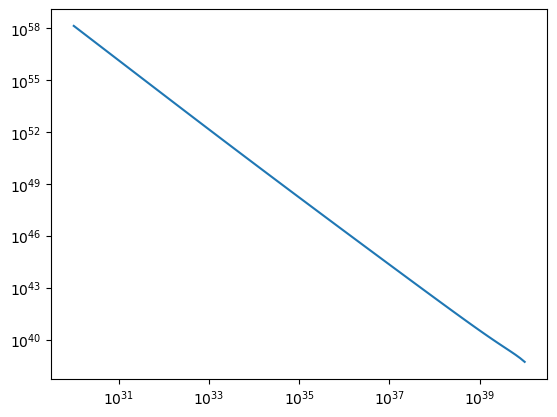

In [14]:
plt.loglog(M_grid,dNdM)